In [ ]:
# @title default setting
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow import keras

data_dir = ""
model_dir = ""
figure_dir = ""

def load_body_data():
    train : dict[str, np.ndarray] = dict()
    test  : dict[str, np.ndarray] = dict()

    train["img"] = np.load(data_dir+"body_train_X1.npy")
    train["sexs"] = np.load(data_dir+"body_sex_train.npy")
    train["ages"] = np.load(data_dir+"body_age_train.npy")
    train["labels"] = np.load(data_dir+"body_train_y.npy")
    test["img"] = np.load(data_dir+"body_test_X1.npy")
    test["sexs"] = np.load(data_dir+"body_sex_test.npy")
    test["ages"] = np.load(data_dir+"body_age_test.npy")
    test["labels"] = np.load(data_dir+"body_test_y.npy")

    return train, test

def split_face_data(train, test, key="img"):

    X = train[key]
    y = train["labels"].reshape(-1).astype(np.int32)

    test_X = test[key]
    test_y = test["labels"].reshape(-1).astype(np.int32)

    indices = np.arange(len(X))
    np.random.seed(123)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    age = np.minimum(train["ages"].reshape(-1)[indices] // 20, 4)

    combined_data = np.column_stack((y, age))
    stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2,  random_state=123)

    # Perform stratified split
    for train_index, val_index in stratified_splitter.split(combined_data, combined_data[:, 0]):
        train_img, valid_img = X[train_index], X[val_index]
        train_labels, valid_labels = y[train_index], y[val_index]

    t_total  = len(train_labels)
    t_P = train_labels.sum()
    t_N = t_total - t_P

    v_total = len(valid_labels)
    v_P = valid_labels.sum()
    v_N = v_total - v_P

    print("X_train shape:", train_img.shape)
    print("y_train shape:", train_labels.shape)
    print("X_val shape:", valid_img.shape)
    print("y_val shape:", valid_labels.shape)
    print("train P:{:.4f}, N:{:.4f}, total:{}".format(t_P/t_total, t_N/t_total, t_total))
    print("valid P:{:.4f}, N:{:.4f}, total:{}".format(v_P/v_total, v_N/v_total, v_total))

    return train_img, train_labels, valid_img, valid_labels, test_X, test_y

def load_models():
    print("start loading model")

    finetuning = keras.models.load_model(model_dir+"new_finetuning_body")
    freeze = keras.models.load_model(model_dir+"freeze_body")
    small = keras.models.load_model(model_dir+"small_body")
    print("end loading model")
    return finetuning, freeze, small

In [ ]:
# @title evaluate
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn


class evaluate:
  def __init__(self, labels, predict, val_labels, val_predict, sex, age):
    self.labels = labels.squeeze()
    self.predict = predict.squeeze()
    self.val_labels = val_labels.squeeze()
    self.val_predict = val_predict.squeeze()
    self.figsize = (10, 10)
    self.threshold = 0.5
    self.sex = sex
    self.age = age

  def set_threshold(self):
    # calculate Youden’s index in valid set
    val_label = self.val_labels.squeeze()
    val_predict = self.val_predict.squeeze()
    def calculate_Y_index(threshold):
      TP = np.logical_and(val_label >= threshold, val_predict >= threshold).sum()
      TN = np.logical_and(val_label < threshold, val_predict <  threshold).sum()
      FP = np.logical_and(val_label < threshold, val_predict >= threshold).sum()
      FN = np.logical_and(val_label >= threshold, val_predict <  threshold).sum()

      assert TP + FN + TN + FP == len(val_label)
      assert TP + FN == val_label.sum()
      assert TN + FP == len(val_label) - val_label.sum()
      Sensitivity = TP / (TP + FN)
      Specificity = TN / (FP + TN)
      return Sensitivity + Specificity

    thresholds = np.sort(val_predict)[1:-1]
    y = np.vectorize(calculate_Y_index)(thresholds)
    self.threshold = thresholds[np.argmax(y)]


  def result(self, labels, predict):
    if len(labels) == 0 or len(scores) == 0:
      labels = self.labels
      predict = self.predict

    labels = labels.squeeze()
    predict = predict.squeeze()
    assert len(labels) == len(predict)

    threshold = self.threshold

    acc = accuracy_score(labels, predict>=threshold)
    auc = roc_auc_score(labels, predict)

    acc = round(acc, 4)
    auc = round(auc, 4)

    print(labels.shape, predict.shape)
    cm = confusion_matrix(labels, predict >= self.threshold)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]

    print(f"{TP=}, {TN=}, {FP=}, {FN=}")


    assert TP + FN == labels.sum()
    assert TN + FP == labels.shape[0] - labels.sum()

    Sensitivity = round(TP / (TP + FN), 4)
    Specificity = round(TN / (FP + TN), 4)
    if TP + FP == 0 or TN + FN == 0:
      PPV = None
      NPV = None
    else:
      PPV = round(TP / (TP + FP), 4)
      NPV = round(TN / (TN + FN), 4)

    return (Sensitivity, Specificity, PPV, NPV, acc, auc)
def group_age_sex(arr, age, sex):

    predict_0_19 =  arr[age<20]
    predict_20_39 = arr[np.logical_and(age>=20, age <40)]
    predict_40_59 = arr[np.logical_and(age>=40, age <60)]
    predict_60 = arr[age>=60]
    predict_20 = arr[age>=20]
    predict_M = arr[sex=='남']
    predict_F = arr[sex=='여']

    return (predict_0_19, predict_20_39, predict_40_59, predict_60, predict_20, predict_M, predict_F)


In [ ]:
# @title function for statistical test
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


def bootstrap_auc(labels : np.ndarray, scores : np.ndarray, n_bootstraps=100000):
    # Calculate AUC for the bootstrap sample
    # Resample scores and labels with replacement
    bootstrap_aucs = []

    for i in range(n_bootstraps):
        if (i+1) % (n_bootstraps//10) ==0:
            print(f"{(i+1)/n_bootstraps*100}%, ", end="")
        # Resample scores and labels with replacement
        indices = resample(np.arange(len(labels)))
        boot_scores = scores[indices]
        boot_labels = labels[indices]

        # Calculate AUC for the bootstrap sample
        auc = roc_auc_score(boot_labels, boot_scores)
        bootstrap_aucs.append(auc)
    print()

    return np.array(bootstrap_aucs)

def CI(metric):
    ci_lower = np.percentile(metric, 2.5)
    ci_upper = np.percentile(metric, 97.5)
    return ci_lower, ci_upper



In [ ]:
# @title load and load model
import os
import numpy as np

train, test = load_body_data()
train_img, train_labels, valid_img, valid_labels, test_X, test_y = split_face_data(train, test)

test_ages = test['ages']
test_sexs = test['sexs']

finetuning, freeze, small = load_models()


if not os.path.isfile(data_dir+"scores.npz"):
    scores = {}
    scores['small'] = small.predict(test_X)
    scores['finetuning'] = finetuning.predict(test_X)
    scores['freeze'] = freeze.predict(test_X)
    np.savez_compressed(data_dir+"scores.npz", **scores)

if not os.path.isfile(data_dir+"val_scores.npz"):
    val_scores = {}
    val_scores['small'] = small.predict(valid_img)
    val_scores['finetuning'] = finetuning.predict(valid_img)
    val_scores['freeze'] = freeze.predict(valid_img)

    np.savez_compressed(data_dir+"val_scores.npz", **val_scores)

scores = np.load(data_dir+"scores.npz")
val_scores = np.load(data_dir+"val_scores.npz")

X_train shape: (1121, 608, 224, 3)
y_train shape: (1121,)
X_val shape: (281, 608, 224, 3)
y_val shape: (281,)
train P:0.7556, N:0.2444, total:1121
valid P:0.7544, N:0.2456, total:281
start loading model
end loading model


In [ ]:
# @title save prediction results in excel file
import pandas as pd
from pathlib import Path

def save_prediction_results_excel():
    trg_path = Path(figure_dir)

    models :dict[str, evaluate]= {}

    for key in scores.keys():
        models[key] : evaluate = evaluate(test_y, scores[key], valid_labels, val_scores[key], test_sexs, test_ages)
        models[key].set_threshold()
        print(models[key].threshold)

    tables = {}
    for key in scores.keys():

        table = pd.DataFrame(columns = ["group","sensitivity", "Specificity","PPV", "NPV", "accuracy", "AUC", "AUC CI"], index=range(1))
        aucs = bootstrap_auc(test_y, scores[key], 10000)
        table.loc[0] = ("Overall", ) + models[key].result(test_y, scores[key])  + ("[{:.4f}, {:.4f}]".format(*CI(aucs)), )

        tables[key] = table

    if os.path.exists(trg_path.joinpath('prediction_results.xlsx')):
        os.remove((trg_path.joinpath('prediction_results.xlsx')))
    for name in tables.keys():
        if not os.path.exists(trg_path.joinpath('prediction_results.xlsx')):
            with pd.ExcelWriter(trg_path.joinpath('prediction_results.xlsx'), mode='w', engine='openpyxl') as writer:
                tables[name].to_excel(writer,sheet_name =name, index=False)
        else:
            with pd.ExcelWriter(trg_path.joinpath('prediction_results.xlsx'), mode='a', engine='openpyxl') as writer:
                tables[name].to_excel(writer,sheet_name =name, index=False)


In [ ]:
save_prediction_results_excel()

0.5152831
0.6615698
0.7330311
10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 
(443,) (443,)
TP=178, TN=62, FP=53, FN=150
10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 
(443,) (443,)
TP=182, TN=76, FP=39, FN=146
10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 
(443,) (443,)
TP=104, TN=99, FP=16, FN=224


In [ ]:
models :dict[str, evaluate]= {}

for key in scores.keys():
    models[key] : evaluate = evaluate(test_y, scores[key], valid_labels, val_scores[key], test_sexs, test_ages)
    models[key].set_threshold()
    print(models[key].threshold)

label_group = group_age_sex(test_y, test_ages.squeeze(), test_sexs.squeeze())
group_names = ("Under 20", "20 - 39", "40 - 59", "Over 60", "Over 20", "Male", "Female")
print("group","sensitivity", "Specificity","PPV", "NPV", "accuracy", "AUC")
for key in scores.keys():
    score_group = group_age_sex(scores[key], test_ages.squeeze(), test_ages.squeeze())
    score_groups :dict[str, np.ndarray] = {}
    label_groups :dict[str, np.ndarray] = {}
    for i in range(len(score_group)):
            score_groups[group_names[i]] = score_group[i]
            label_groups[group_names[i]] = label_group[i]

    for name in group_names:
        print(name, models[key].result(label_groups[name], score_groups[name]))
        print()

0.6615698
0.7330311
group sensitivity Specificity PPV NPV accuracy AUC
(73,) (73,)
TP=65, TN=1, FP=2, FN=5
Under 20 (0.9286, 0.3333, 0.9701, 0.1667, 0.9041, 0.6524)

(166,) (166,)
TP=81, TN=12, FP=25, FN=48
20 - 39 (0.6279, 0.3243, 0.7642, 0.2, 0.5602, 0.5106)

(119,) (119,)
TP=21, TN=36, FP=9, FN=53
40 - 59 (0.2838, 0.8, 0.7, 0.4045, 0.479, 0.5869)

(85,) (85,)
TP=15, TN=27, FP=3, FN=40
Over 60 (0.2727, 0.9, 0.8333, 0.403, 0.4941, 0.6048)

(370,) (370,)
TP=117, TN=75, FP=37, FN=141
Over 20 (0.4535, 0.6696, 0.7597, 0.3472, 0.5189, 0.5991)

(443,) (443,)
TP=182, TN=76, FP=39, FN=146
Male (0.5549, 0.6609, 0.8235, 0.3423, 0.5824, 0.6537)

(443,) (443,)
TP=182, TN=76, FP=39, FN=146
Female (0.5549, 0.6609, 0.8235, 0.3423, 0.5824, 0.6537)

(73,) (73,)
TP=47, TN=1, FP=2, FN=23
Under 20 (0.6714, 0.3333, 0.9592, 0.0417, 0.6575, 0.619)

(166,) (166,)
TP=49, TN=25, FP=12, FN=80
20 - 39 (0.3798, 0.6757, 0.8033, 0.2381, 0.4458, 0.5353)

(119,) (119,)
TP=5, TN=43, FP=2, FN=69
40 - 59 (0.0676, 0.9556

In [ ]:
save_prediction_results_excel()

0.6615698
0.7330311
10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 
(443,) (443,)
TP=182, TN=76, FP=39, FN=146
10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 
(443,) (443,)
TP=104, TN=99, FP=16, FN=224


In [ ]:
# @title plot functions: plot_cm(), plot_roc(), save_graph()
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_cm(labels, predictions, p=0.5, **kwargs):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d",**kwargs)
    #plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual Values', fontsize=20)
    plt.xlabel('Predicted Values', fontsize=20)

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):

    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=4, **kwargs)
    plt.xlabel('False positives', fontsize=20)
    plt.ylabel('True positives', fontsize=20)
    plt.grid(True)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    #plt.axis("off")
    ax = plt.gca()
    ax.set_aspect(aspect=1)


def save_graph(key, color, cmap):
    trg_path = Path(figure_dir)

    label_group = group_age_sex(test_y, test_ages.squeeze(), test_sexs.squeeze())
    model : evaluate = evaluate(test_y, scores[key], valid_labels, val_scores[key], test_sexs, test_ages)
    model.set_threshold()

    group_names = ("Overall", "Under 20", "20 - 39", "40 - 59", "Over 60", "Over 20", "Male", "Female")
    score_group = group_age_sex(scores[key], test_ages.squeeze(), test_sexs.squeeze())

    score_groups :dict[str, np.ndarray] = {}
    label_groups :dict[str, np.ndarray] = {}
    score_groups[group_names[0]] = scores[key]
    label_groups[group_names[0]] = test_y
    for i in range(len(score_group)):
        score_groups[group_names[i+1]] = score_group[i]
        label_groups[group_names[i+1]] = label_group[i]

    auc = roc_auc_score(label_groups["Overall"], score_groups["Overall"])

    # plot ROC curve of model
    plt.figure(figsize=(6,6))
    plot_roc("AUC={:.4f}".format(auc), label_groups["Overall"], score_groups["Overall"], color=color)
    plt.plot([0,100], [0,100], linestyle = '--', color = 'k')
    plt.legend(loc='lower right', fontsize=20)
    plt.savefig(trg_path.joinpath("{}_AUC_graph.png".format(key)))

    plot_cm(label_groups["Overall"], score_groups["Overall"], p=model.threshold, vmin=0, vmax=250, cmap=cmap , annot_kws={"size": 20})
    plt.savefig(trg_path.joinpath("{}_CM.png".format(key)))


Legitimate Transactions Detected (True Negatives):  76
Legitimate Transactions Incorrectly Detected (False Positives):  39
Fraudulent Transactions Missed (False Negatives):  146
Fraudulent Transactions Detected (True Positives):  182
Total Fraudulent Transactions:  328
Legitimate Transactions Detected (True Negatives):  99
Legitimate Transactions Incorrectly Detected (False Positives):  16
Fraudulent Transactions Missed (False Negatives):  224
Fraudulent Transactions Detected (True Positives):  104
Total Fraudulent Transactions:  328
Legitimate Transactions Detected (True Negatives):  62
Legitimate Transactions Incorrectly Detected (False Positives):  53
Fraudulent Transactions Missed (False Negatives):  150
Fraudulent Transactions Detected (True Positives):  178
Total Fraudulent Transactions:  328


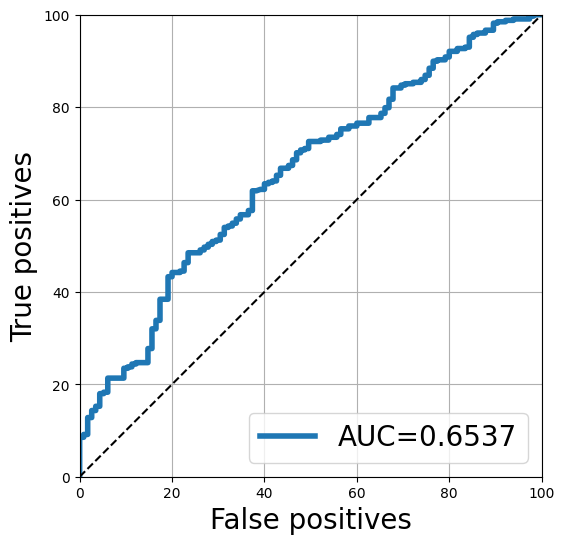

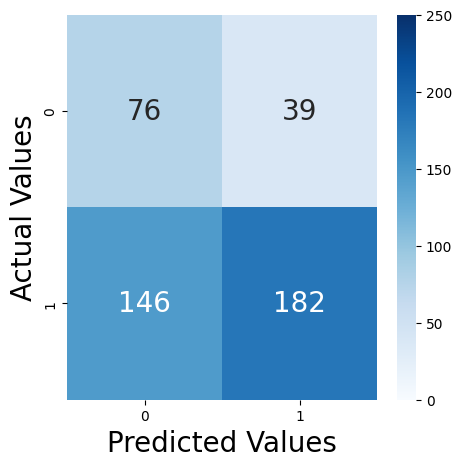

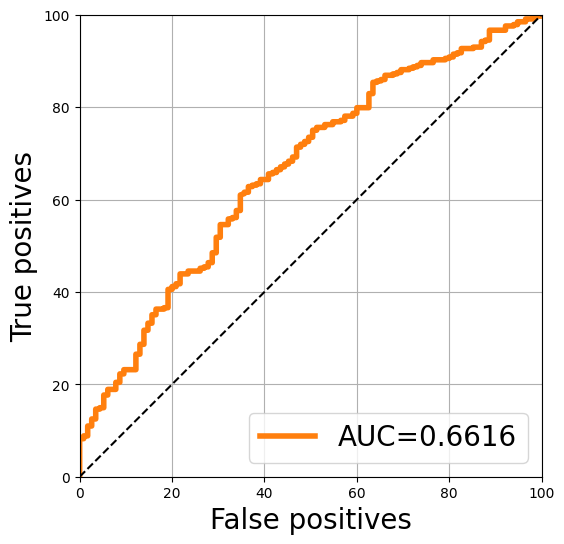

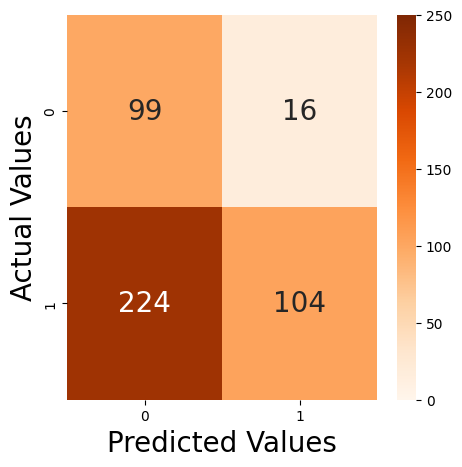

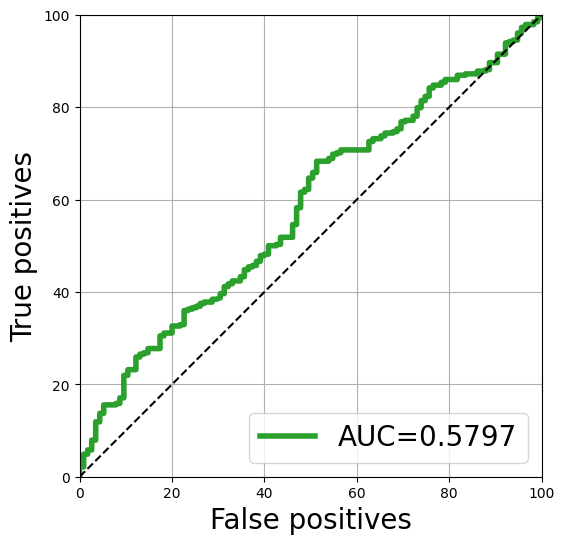

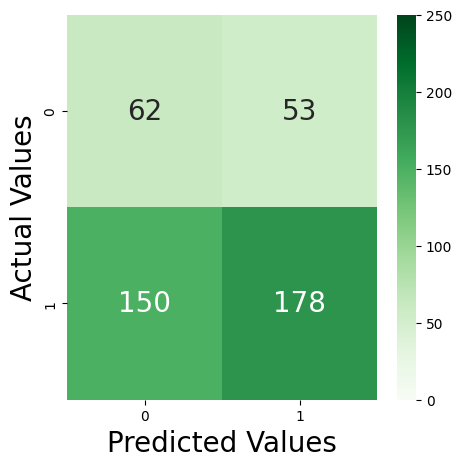

In [ ]:
save_graph("finetuning", colors[0], "Blues")
save_graph("freeze", colors[1], "Oranges")
save_graph("small", colors[2], "Greens")

1/1 [==============================] - 4s 4s/step
sparsity: 0.9215188851033834


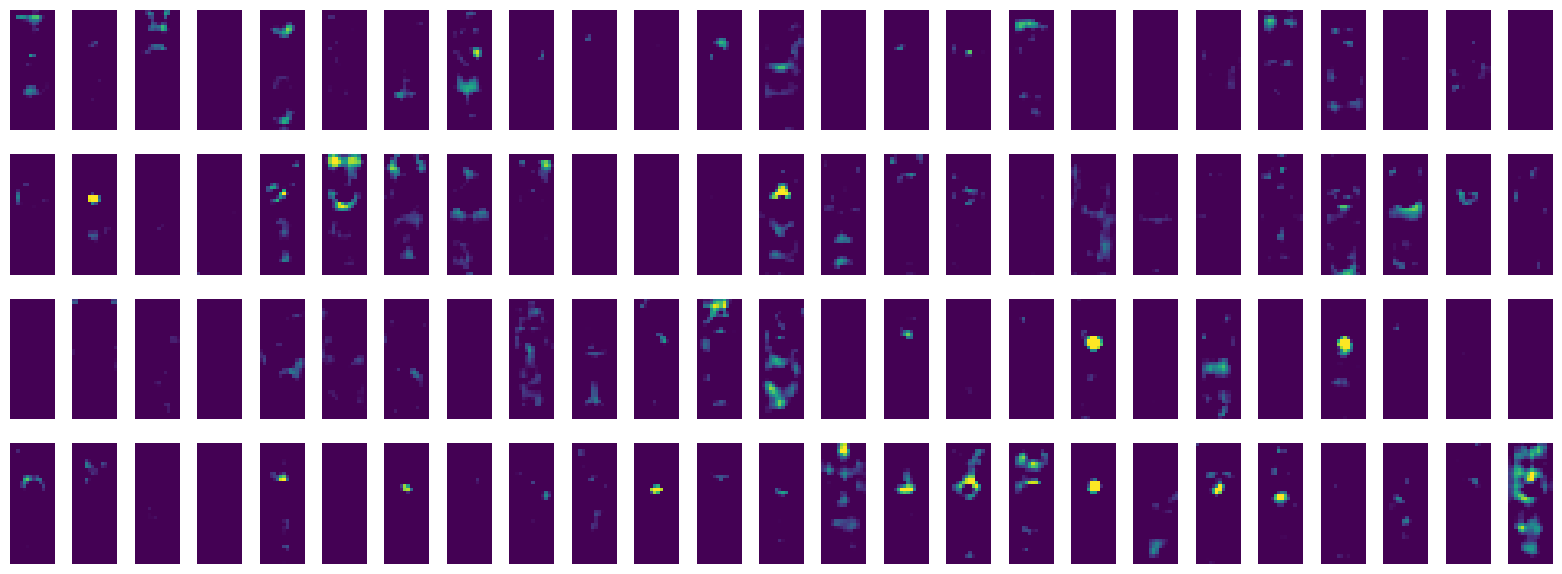

1/1 [==============================] - 0s 135ms/step
sparsity: 0.930913710056391


<Figure size 2000x720 with 0 Axes>

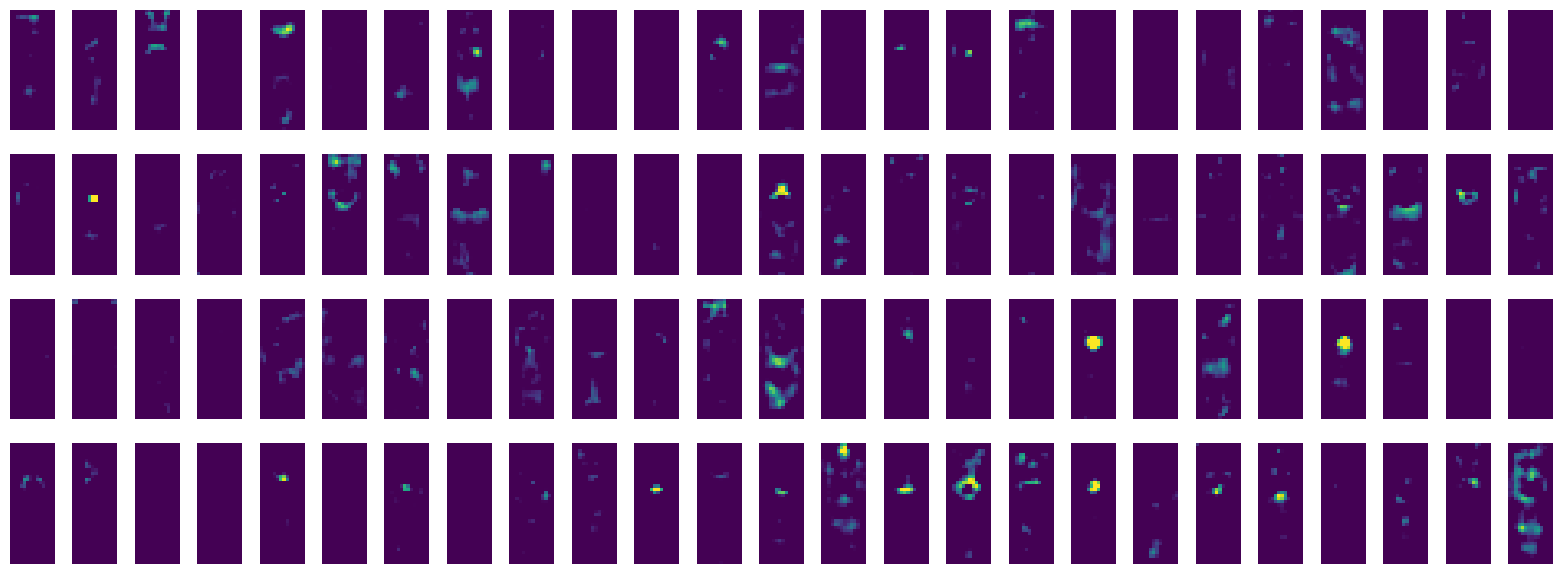

In [ ]:
# @title show last channel activation map
from pathlib import Path
import matplotlib.pyplot as plt

# finetuning, freeze = load_models()
act_model = grad_model = keras.models.Model(
        [finetuning.inputs], [finetuning.layers[-6].output]
    )
feature_maps = act_model.predict(test_X[57:58])
m = np.max(feature_maps)
print(f"sparsity: {np.sum(feature_maps <= 0)/ sum(feature_maps.flatten().shape) }")

trg_path = Path(figure_dir)
plt.figure(figsize=(20, 7.2))
for i in range(0, 100):
    ax = plt.subplot(4, 25, i+1)
    ax.matshow(feature_maps[0, :, :, i], vmin=0, vmax=m/3)
    ax.axis('off')
plt.savefig(trg_path.joinpath("finetuning_last_channel_activation_map.png"), bbox_inches="tight")
plt.show()
plt.figure(figsize=(20, 7.2))
# plt.savefig(trg_path.joinpath("finetuning_last_channel_activation_map.png"))
act_model = grad_model = keras.models.Model(
        [freeze.inputs], [freeze.layers[-6].output]
    )
feature_maps = act_model.predict(test_X[57:58])
print(f"sparsity: {np.sum(feature_maps <= 0)/ sum(feature_maps.flatten().shape) }")
m = np.max(feature_maps)
plt.figure(figsize=(20, 7.2))
for i in range(0, 100):
    ax = plt.subplot(4, 25, i+1)
    ax.matshow(feature_maps[0, :, :, i], vmin=0, vmax=m/3)
    ax.axis('off')
plt.savefig(trg_path.joinpath("freeze_last_channel_activation_map.png"), bbox_inches="tight")
plt.show()



In [ ]:
# @title gradcam
import matplotlib.cm as cm
import cv2
import colorsys
import colorsys
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import tensorflow as tf
from PIL import Image


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Forward pass. Note that `training` is set to False.
        # This ensures that the model's layers are in inference mode.
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        # Since we are interested in the positive class (class "1"), we select the output probability
        # for the positive class, which is the model's output directly in binary classification.
        class_channel = preds[:, 0]

    # Compute gradients of the class (positive class) w.r.t. the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Global average pooling of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    #pooled_grads = tf.maximum(pooled_grads, 0)

    # Weight the output feature map with the computed pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap to make the values between 0 and 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def gradcam_scale(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_sum(grads, axis=(0, 1, 2))

    # Weight the output feature map with the computed pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    return np.max(heatmap), np.min(heatmap)

def gradcam_with_img(img, heatmap, alpha=0.4):

    def cut(x):
        return 0 if x < 70 else x

    heatmap = np.uint8(255 * heatmap)
    heatmap = np.vectorize(cut)(heatmap)
    #히트맵을 위한 칼라맵 설정

    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # cmap2 = get_cmap2()
    # jet_heatmap = cmap2[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]), Image.BILINEAR)
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)


    superimposed_img = img*0.6
    superimposed_img += (jet_heatmap)*alpha
    superimposed_img = np.clip(superimposed_img, 0, 255)
    superimposed_img = np.uint8(superimposed_img)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img




In [ ]:
finetuning.layers[-1].activation = None
freeze.layers[-1].activation = None
finetuning.compile()
freeze.compile()

In [ ]:
num = 240
indices = np.arange(num)[np.logical_and(test_y[:num]==1, scores["finetuning"][:num].squeeze() >0.6615)]
print(indices)

[  0   3   8  12  13  16  18  22  24  27  28  34  37  39  41  42  43  45
  48  50  51  53  54  55  57  59  60  64  65  67  72  73  74  79  86  87
  88  89  90  94  97  98  99 106 110 111 112 115 116 117 119 120 121 123
 126 127 130 132 133 142 145 148 152 156 159 160 163 164 166 167 168 169
 170 174 175 184 186 187 188 189 192 195 199 200 201 203 207 208 209 212
 213 215 217 218 219 221 222 223 225 226 229 231 232 233 234 237]


In [ ]:



heatmaps = np.zeros((num, 38, 14))
for i in indices:
    heatmap = make_gradcam_heatmap(test_X[i:i+1], finetuning, 'block5_conv3')
    heatmaps[i] = heatmap

for i in indices:
    gradcam_img = gradcam_with_img(test_X[i], heatmaps[i])
    filename = figure_dir + "gradcam/fine_gradcam_" + str(i)+".png"
    keras.utils.save_img(filename, gradcam_img)

indices = np.arange(num)[np.logical_and(test_y[:num]==1, scores["freeze"][:num].squeeze() >0.7330)]
heatmaps = np.zeros((num, 38, 14))
for i in indices:
    heatmap = make_gradcam_heatmap(test_X[i:i+1], freeze, 'block5_conv3')
    heatmaps[i] = heatmap

for i in indices:
    gradcam_img = gradcam_with_img(test_X[i], heatmaps[i])
    filename = figure_dir + "gradcam/freeze_gradcam_" + str(i)+".png"
    keras.utils.save_img(filename, gradcam_img)

In [ ]:
indices = np.arange(num)[np.logical_and(test_y[:num]==0, scores["finetuning"][:num].squeeze() <0.6615)]
heatmaps = np.zeros((num, 38, 14))
for i in indices:
    heatmap = make_gradcam_heatmap(test_X[i:i+1], finetuning, 'block5_conv3')
    heatmaps[i] = heatmap

for i in indices:
    gradcam_img = gradcam_with_img(test_X[i], heatmaps[i])
    filename = figure_dir + "gradcam/TN/fine_gradcam_" + str(i)+".png"
    keras.utils.save_img(filename, gradcam_img)

indices = np.arange(num)[np.logical_and(test_y[:num]==0, scores["freeze"][:num].squeeze() <0.7330)]
heatmaps = np.zeros((num, 38, 14))
for i in indices:
    heatmap = make_gradcam_heatmap(test_X[i:i+1], freeze, 'block5_conv3')
    heatmaps[i] = heatmap

for i in indices:
    gradcam_img = gradcam_with_img(test_X[i], heatmaps[i])
    filename = figure_dir + "gradcam/TN/freeze_gradcam_" + str(i)+".png"
    keras.utils.save_img(filename, gradcam_img)

In [ ]:
# @title statistical test

%pip install MLstatkit

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
import scipy.stats as stats
from MLstatkit.stats import Delong_test


z_score, p_value = Delong_test(test_y, scores["small"].squeeze(), scores["finetuning"].squeeze())

print("small vs fine | "+f"Z-Score: {z_score}, P-Value: {p_value}")
z_score, p_value = Delong_test(test_y, scores["freeze"].squeeze(), scores["small"].squeeze())

print("freeze vs small | "+f"Z-Score: {z_score}, P-Value: {p_value}")
z_score, p_value = Delong_test(test_y, scores["freeze"].squeeze(), scores["finetuning"].squeeze())

print("freeze vs fine | "+f"Z-Score: {z_score}, P-Value: {p_value}")

small vs fine | Z-Score: -2.1793551177869563, P-Value: 0.02930529758893459
freeze vs small | Z-Score: -2.4109649086842175, P-Value: 0.01591037917029599
freeze vs fine | Z-Score: -0.7798445253069514, P-Value: 0.43548239468862127


In [ ]:
# @title ensemble

esemble_scores = scores["freeze"].squeeze()  +scores["finetuning"].squeeze()
esemble_scores += scores["small"].squeeze()
esemble_scores /= 3
esemble_val_score = val_scores["freeze"].squeeze() + val_scores["finetuning"].squeeze()
esemble_val_score += val_scores["small"].squeeze()
esemble_val_score /= 3

print(esemble_scores.min(), esemble_scores.max())
esembel_model : evaluate = evaluate(test_y, esemble_scores, valid_labels, esemble_val_score, test_sexs, test_ages)


0.48568907 0.731579


In [ ]:
esembel_model.set_threshold()
print(esembel_model.threshold)

esembel_model.result(test_y, esemble_scores)

0.61626524
(443,) (443,)
TP=198, TN=71, FP=44, FN=130


(0.6037, 0.6174, 0.8182, 0.3532, 0.6072, 0.6609)